In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from diff_music.data.dataset import PianorollDataset
from music_data_analysis import show_pianoroll
ds_path = Path(r'W:\music\music-data-analysis\data')
# ds = PianorollDataset(Path('W:\\piano-ai\\pop80k_k'), frames_per_beat=8, length=32*4)
ds = PianorollDataset(ds_path, frames_per_beat=8, length=32*4)
show_pianoroll(ds[10])

PianorollDataset initialized with 20078 segments from 2570 songs


AttributeError: 'Pianoroll' object has no attribute 'detach'

In [3]:
from diff_music.models.transformer import PianorollDenoiser
import torch
from torch import Tensor
from torch.utils.data import DataLoader

from diff_music.models.video_diff import VideoDiffusion

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# denoiser_params = PianorollDenoiser.Params(
#     dim=256,
#     max_length=256,
#     depth=3,
#     heads=8,
#     rotary_pos_emb=True,
#     time_conv_dilations=[1, 2, 4, 8, 16],
#     pitch_conv_dilations=[1, 2, 7, 12],
#     attn_type='linear',
# )
# denoiser = PianorollDenoiser(denoiser_params, 1).to(device)

denoiser_params = VideoDiffusion.Params(
    dim=768,
    max_length=128,
    depth=8,
    heads=8,
    rotary_pos_emb=True,
    frames_per_bar=32,
    local_attn_window_size=128,
)
denoiser = VideoDiffusion(denoiser_params, 1).to(device)

total_params = sum(p.numel() for p in denoiser.parameters())
print(f"Total parameters: {total_params/1e6:.2f}M")

x0 = torch.randn(1, 1, 128, 88).to(device)
time_steps = torch.randint(0, 64, (1,)).to(device)
denoiser(x0, time_steps).shape

Total parameters: 88.30M


c:\Users\User\miniconda3\envs\gr\Lib\site-packages\x_transformers\attend.py:395: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  out = F.scaled_dot_product_attention(


torch.Size([1, 1, 128, 88])

In [4]:
from diff_music.binary_diffusion import BinaryDiffusion
diff_params = BinaryDiffusion.Params(
    total_steps=1024,
    loss_final='weighted',
    use_softmax=True,
    beta_type='linear',
    p_flip=False,
    aux=0,
    use_label=False,
    guidance=0.0,
    channels=1,
    focal_alpha=0.5,
    focal_gamma=0,
    gamma=0.5,
)
diff = BinaryDiffusion(diff_params, denoiser).to(device)

Noise scheduler with linear:
Diffusion 1.0 -> 0.5:
1.0000 0.9995 0.9990 0.9985 0.9980 0.9976 0.9971 0.9966 0.9961 0.9956 0.9951 0.9946 0.9941 0.9937 0.9932 0.9927 0.9922 0.9917 0.9912 0.9907 0.9902 0.9897 0.9893 0.9888 0.9883 0.9878 0.9873 0.9868 0.9863 0.9858 0.9854 0.9849 0.9844 0.9839 0.9834 0.9829 0.9824 0.9819 0.9814 0.9810 0.9805 0.9800 0.9795 0.9790 0.9785 0.9780 0.9775 0.9771 0.9766 0.9761 0.9756 0.9751 0.9746 0.9741 0.9736 0.9731 0.9727 0.9722 0.9717 0.9712 0.9707 0.9702 0.9697 0.9692 0.9688 0.9683 0.9678 0.9673 0.9668 0.9663 0.9658 0.9653 0.9648 0.9644 0.9639 0.9634 0.9629 0.9624 0.9619 0.9614 0.9609 0.9604 0.9600 0.9595 0.9590 0.9585 0.9580 0.9575 0.9570 0.9565 0.9561 0.9556 0.9551 0.9546 0.9541 0.9536 0.9531 0.9526 0.9521 0.9517 0.9512 0.9507 0.9502 0.9497 0.9492 0.9487 0.9482 0.9478 0.9473 0.9468 0.9463 0.9458 0.9453 0.9448 0.9443 0.9438 0.9434 0.9429 0.9424 0.9419 0.9414 0.9409 0.9404 0.9399 0.9395 0.9390 0.9385 0.9380 0.9375 0.9370 0.9365 0.9360 0.9355 0.9351 0.9346 0.93

In [5]:
from dataclasses import dataclass


@dataclass
class TrainingParams:
    lr: float
    epochs: int
    batch_size: int
    generate_steps: int
    save_steps: int
    num_workers: int = 0

training_params = TrainingParams(
    lr=2e-4,
    epochs=100,
    batch_size=16,
    generate_steps=500,
    save_steps=10000,
    num_workers=6,
)


In [6]:
class FocalAlphaScheduler:
    def __init__(self, num_successive_non_zeros=2000, focal_alpha=0.95, decay_steps=2000):
        self.thres_successive_non_zeros = num_successive_non_zeros
        self.successive_non_zeros = 0
        self.start_focal_alpha = focal_alpha
        self.target_focal_alpha = 0.5
        self.decay_steps = decay_steps
        self.last_step = -1

        self.phase = 'init'
        self.start_decay_step = 0

    def inform_non_zero(self, step:int, non_zero:bool):
        step_delta = step - self.last_step
        self.last_step = step
        
        if non_zero:
            self.successive_non_zeros += step_delta
        else:
            self.successive_non_zeros = 0
    def get(self, step:int)->float:

        if self.phase == 'init':
            if self.successive_non_zeros > self.thres_successive_non_zeros:
                self.start_decay_step = step
                self.phase = 'decay'

            return self.start_focal_alpha
        
        if self.phase == 'decay':

            if step >= self.start_decay_step + self.decay_steps:
                self.phase = 'end'

            return self.start_focal_alpha + ( self.target_focal_alpha - self.start_focal_alpha) * (step - self.start_decay_step) / self.decay_steps
        
        if self.phase == 'end':
            return self.target_focal_alpha

        raise ValueError(f"Unknown phase {self.phase}")


@dataclass
class FocalParams:
    num_successive_non_zeros: int
    focal_alpha: float
    decay_steps: int

focal_params = FocalParams( num_successive_non_zeros=2000, focal_alpha=0.5, decay_steps=2000)


In [7]:
from datetime import datetime
import wandb
run = wandb.init(
    # Set the project where this run will be logged
    project="vqpiano",
    group="binary-diffusion",
    id=datetime.now().strftime("%Y%m%d_%H%M%S"),
    # Track hyperparameters and run metadata
    config={
        "training": training_params,
        "focal": focal_params,
        "denoiser": denoiser_params,
        "diffusion": diff_params,
        "ds_path": ds_path,
    },
)

wandb: Currently logged in as: eri24816 (tanchihpin0517-team) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [8]:

dataloader = DataLoader(ds, batch_size=training_params.batch_size, shuffle=True, num_workers=training_params.num_workers, persistent_workers=True)

step = 0
optim = torch.optim.Adam(diff.parameters(), lr=training_params.lr)

In [9]:

from music_data_analysis import Pianoroll
from tqdm import tqdm
import einops

import torch_util
import torch_util.wandb

import time
class HZLimiter:
    '''
    if too fast sleep until next hz
    '''
    def __init__(self, hz=1):
        self.hz = hz
        self.last_time = 0
        self.interval = 1/hz

    def __call__(self):
        if time.time() - self.last_time < self.interval:
            time.sleep(self.interval - (time.time() - self.last_time))
        self.last_time = time.time()

    
limiter = HZLimiter(10)


focal_scheduler = FocalAlphaScheduler(**focal_params.__dict__)

diff.train()

for epoch in range(training_params.epochs):
    progress = tqdm(dataloader)
    for x0 in progress:
        limiter()
        diff.focal_alpha = focal_scheduler.get(step)
        
        x0: torch.Tensor
        x0 = x0.to(device)
        
        lossess = diff(x0.unsqueeze(1))
        loss = lossess['loss']
        bce_loss = lossess['bce_loss']
        optim.zero_grad()
        loss.backward()
        optim.step()
        progress.set_postfix(loss=loss.item())

        wandb.log({
            'loss': loss.item(),
            'bce': bce_loss.item(),
            'focal_alpha': diff.focal_alpha,
        }, step=step)

        if (step < training_params.generate_steps*2 and step % (training_params.generate_steps//5) == 0)\
        or (step % training_params.generate_steps == 0):
            diff.eval()
            sampled = diff.sample((1, 1, 128, 88),return_all=True).detach().cpu()
            
            T = sampled.shape[1]
            num_display_steps = 4
            display_steps = [0] + list(reversed([T -1 - i * (T // num_display_steps) for i in range(num_display_steps)]))

            denoising_proc_img = einops.rearrange(sampled[:,display_steps].flip(4), 'b t c h w -> c (t w) (b h)')
            torch_util.wandb.log_image(denoising_proc_img, 'denoising', step)

            denoising_proc_img = einops.rearrange(sampled[:,[0,1,2,3,4]].flip(4), 'b t c h w -> c (t w) (b h)')
            torch_util.wandb.log_image(denoising_proc_img, 'denoising_last', step)

            x0_sampled = sampled[0,0,0]
            
            torch_util.wandb.log_image(einops.rearrange(x0_sampled.flip(1), 't p -> p t'), 'x0', step)

            torch_util.wandb.log_image(diff.get_forwarding_x_t(x0[0], display_steps), 'forwarding_x_t', step)

            pr = Pianoroll.from_tensor(x0_sampled, frames_per_beat=8, binary=True)
            torch_util.wandb.log_midi_as_audio(pr.to_midi(), 'audio', step)

            focal_scheduler.inform_non_zero(step, bool(x0_sampled.sum() > 0))
            diff.train()

        if training_params.save_steps > 0 and step % training_params.save_steps == 0:
            torch.save(diff.state_dict(), Path(wandb.run.dir) / f'diff_{step}.pth')

        step += 1

 15%|█▍        | 182/1255 [00:27<02:43,  6.57it/s, loss=0.018] 


KeyboardInterrupt: 

In [ ]:
pr = Pianoroll.from_tensor(x0[0], frames_per_beat=8, binary=True)
pr.to_midi('output.mid')

ticks per beat: 480
max tick: 0
tempo changes: 1
time sig: 0
key sig: 0
markers: 0
lyrics: False
instruments: 1

ticks per beat: 480
max tick: 0
tempo changes: 1
time sig: 0
key sig: 0
markers: 0
lyrics: False
instruments: 1

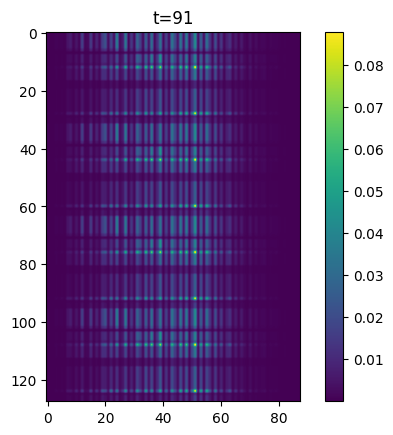

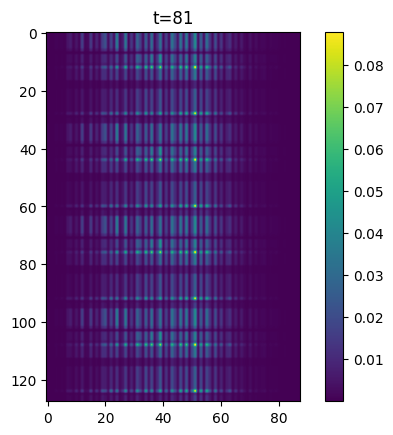

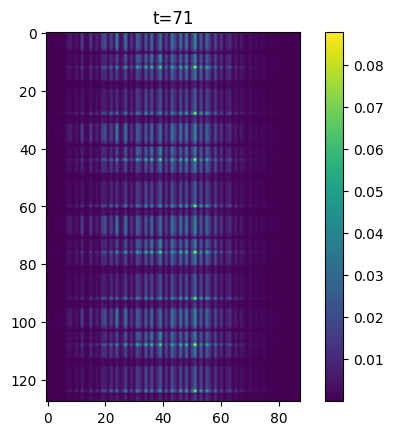

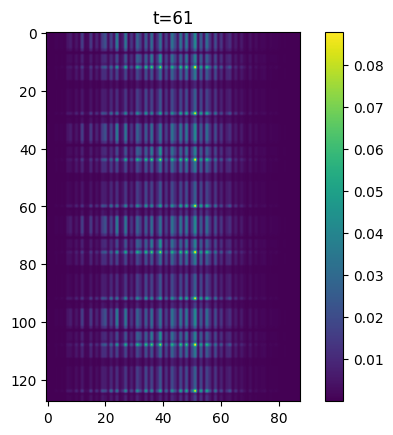

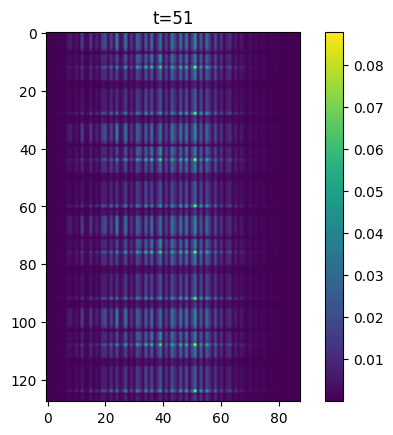

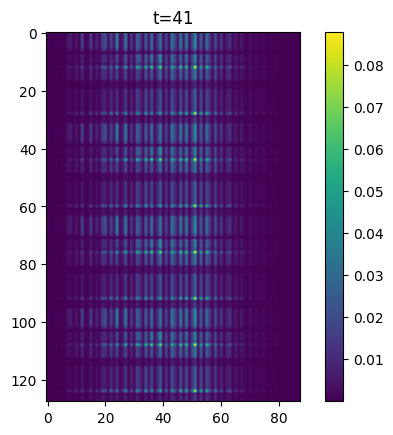

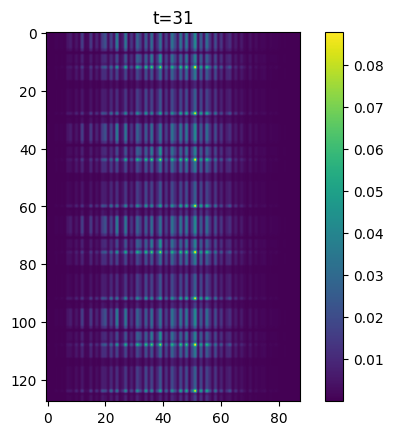

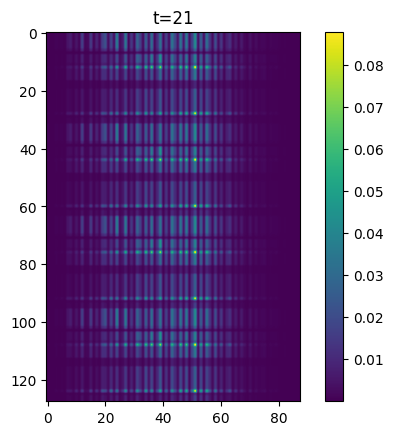

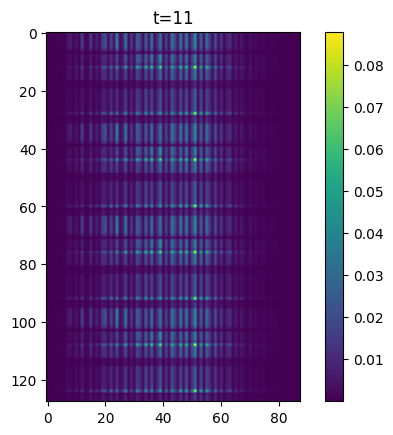

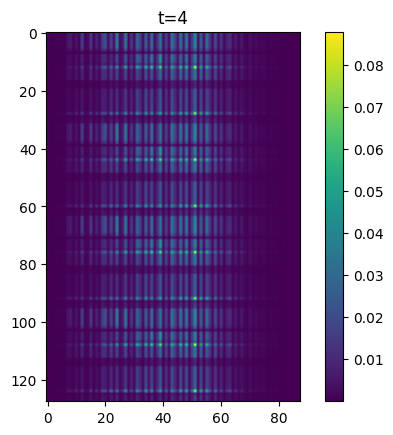

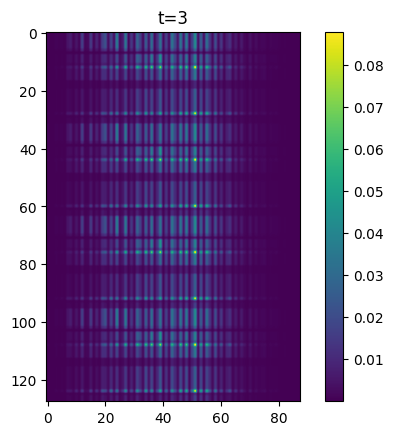

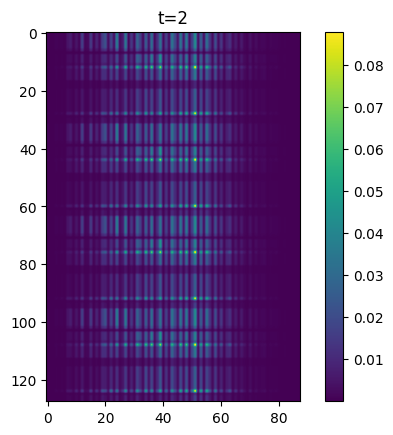

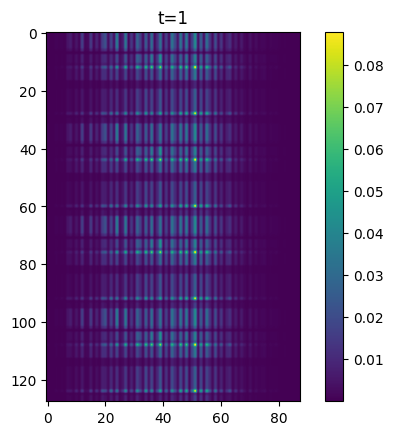

In [13]:
from matplotlib import pyplot as plt
diff.eval()
# sampled = diff.sample((1, 1, 256, 88),return_all=True).detach().cpu()
# T = sampled.shape[1]

# num_display_steps = 4
# display_steps = [0] + list(reversed([T -1 - i * (T // num_display_steps) for i in range(num_display_steps)]))
# display_steps = [0,1,2,3,4]
# denoising_proc_img = einops.rearrange(sampled[:,display_steps], 'b t c h w -> c (t w) (b h)')
# plt.figure(figsize=(10,10))
# plt.imshow(denoising_proc_img[0])
# x0_sampled = sampled[0,0,0]

x0_sampled = diff.sample((1, 1, 128, 88)).detach().cpu()[0,0]

pr = Pianoroll.from_tensor(x0_sampled, frames_per_beat=8, binary=True)
pr.to_midi('output.mid')

In [20]:
denoising_proc_img[0][80:390]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

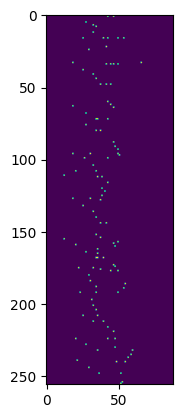

In [61]:
import einops
import matplotlib.pyplot as plt
from music_data_analysis import Pianoroll
diff.eval()
T = sampled.shape[1]
num_display_steps = 4
#display_steps = [0] + list(reversed([T -1 - i * (T // num_display_steps) for i in range(num_display_steps)]))
display_steps = [0,1]
# dataloader = DataLoader(ds, batch_size=1, shuffle=True)

# x0 = next(iter(dataloader)).to(device)


plt.imshow(torch.bernoulli(diff.scheduler(x0[0], 2).cpu()))

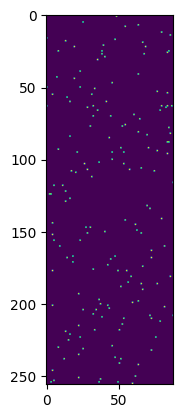

In [ ]:
plt.imshow(torch.bernoulli(diff.gamma * torch.ones(x0.shape, device=device)).cpu()[0])

tensor(0.0341, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0174, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0055, device='cuda:0', grad_fn=<MseLossBackward0>)


KeyboardInterrupt: 

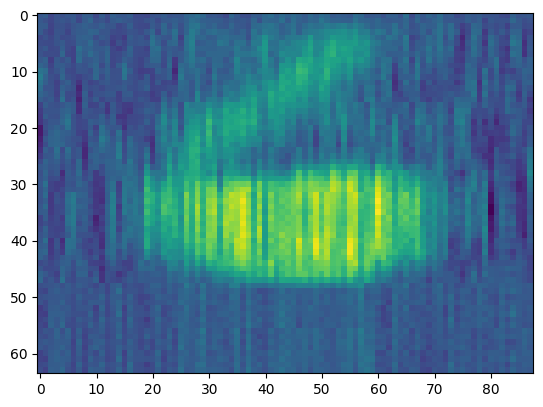

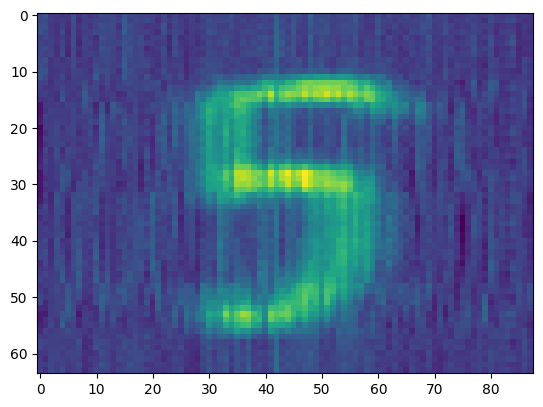

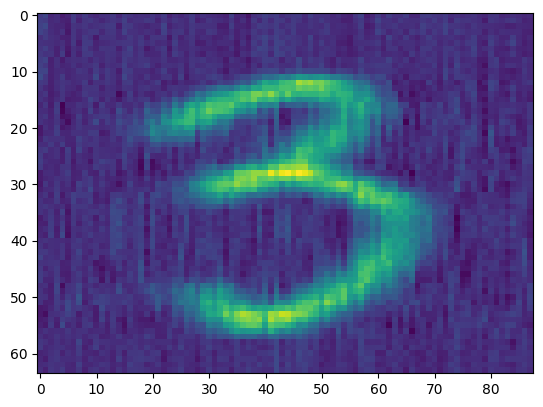

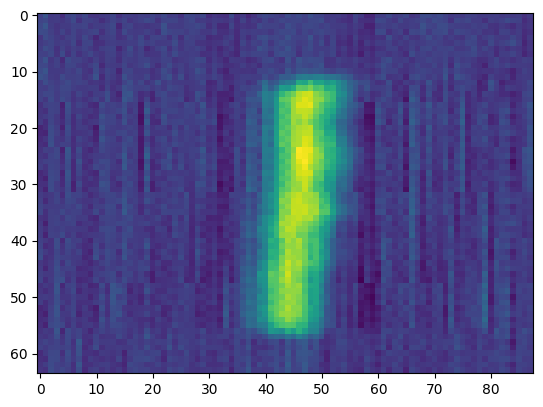

In [66]:
# create mnist dataset
import torchvision
mnist = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=
                                   torchvision.transforms.Compose([
                                       torchvision.transforms.ToTensor(),
                                       torchvision.transforms.Resize((64,88))
                                   ]))

dl = DataLoader(mnist, batch_size=32, shuffle=True)
optim = torch.optim.Adam(denoiser.parameters(), lr=1e-3)

for i, (x0,_) in enumerate(dl):
    x0 = x0.to(device)
    pred = denoiser(x0, torch.ones((x0.shape[0],), device=device))
    loss = torch.nn.functional.mse_loss(pred, x0)
    optim.zero_grad()
    loss.backward()
    optim.step()

    if i % 100 == 0:
        plt.figure()
        plt.imshow(pred[0][0].detach().cpu().numpy())
        
        print(loss)
    


In [64]:
denoiser_params = VideoDiffusion.Params(
    dim=768,
    max_length=256,
    depth=6,
    heads=8,
    rotary_pos_emb=True,
    frames_per_bar=32,
)
denoiser = VideoDiffusion(denoiser_params, 1).to(device)


In [31]:
pred = denoiser(x0, torch.ones((x0.shape[0],), device=device))
plt.imshow(pred[0][0].detach().cpu().numpy())

tensor(0., device='cuda:0')

In [ ]:
denoiser

VideoDiffusion(
  (in_layer): Linear(in_features=89, out_features=768, bias=True)
  (frame_attn_blocks): ModuleList(
    (0-5): 6 x AttentionLayers(
      (layers): ModuleList(
        (0): ModuleList(
          (0): ModuleList(
            (0): LayerNorm(
              (ln): LayerNorm((768,), eps=1e-05, elementwise_affine=False)
            )
            (1-2): 2 x None
          )
          (1): Attention(
            (to_q): Linear(in_features=768, out_features=512, bias=False)
            (to_k): Linear(in_features=768, out_features=512, bias=False)
            (to_v): Linear(in_features=768, out_features=512, bias=False)
            (split_q_heads): Rearrange('b n (h d) -> b h n d', h=8)
            (split_k_heads): Rearrange('b n (h d) -> b h n d', d=64)
            (split_v_heads): Rearrange('b n (h d) -> b h n d', d=64)
            (merge_heads): Rearrange('b h n d -> b n (h d)')
            (attend): Attend(
              (attn_dropout): Dropout(p=0.0, inplace=False)
         

Noise scheduler with linear:
Diffusion 1.0 -> 0.5:
1.0000 0.9845 0.9690 0.9535 0.9380 0.9224 0.9069 0.8914 0.8759 0.8604 0.8449 0.8294 0.8138 0.7983 0.7828 0.7673 0.7518 0.7363 0.7208 0.7053 0.6898 0.6742 0.6587 0.6432 0.6277 0.6122 0.5967 0.5812 0.5656 0.5501 0.5346 0.5191 0.5036 0.4881 0.4726 0.4571 0.4415 0.4260 0.4105 0.3950 0.3795 0.3640 0.3485 0.3330 0.3174 0.3019 0.2864 0.2709 0.2554 0.2399 0.2244 0.2089 0.1934 0.1778 0.1623 0.1468 0.1313 0.1158 0.1003 0.0848 0.0693 0.0537 0.0382 0.0227 0.0072
Diffusion 0.0 -> 0.5:
0.0000 0.0001 0.0002 0.0003 0.0004 0.0006 0.0007 0.0008 0.0009 0.0010 0.0011 0.0012 0.0014 0.0015 0.0016 0.0017 0.0018 0.0019 0.0020 0.0021 0.0022 0.0024 0.0025 0.0026 0.0027 0.0028 0.0029 0.0030 0.0032 0.0033 0.0034 0.0035 0.0036 0.0037 0.0038 0.0039 0.0041 0.0042 0.0043 0.0044 0.0045 0.0046 0.0047 0.0048 0.0049 0.0051 0.0052 0.0053 0.0054 0.0055 0.0056 0.0057 0.0058 0.0060 0.0061 0.0062 0.0063 0.0064 0.0065 0.0066 0.0068 0.0069 0.0070 0.0071 0.0072
Beta:
0.0000 0.01

C:\Users\User\AppData\Local\Temp\ipykernel_2008\1312176365.py:23: RuntimeWarning: divide by zero encountered in log2
  return -self.px0y0*np.log2(self.px0y0)-self.px0y1*np.log2(self.px0y1)-self.px1y0*np.log2(self.px1y0)-self.px1y1*np.log2(self.px1y1)
C:\Users\User\AppData\Local\Temp\ipykernel_2008\1312176365.py:23: RuntimeWarning: invalid value encountered in scalar multiply
  return -self.px0y0*np.log2(self.px0y0)-self.px0y1*np.log2(self.px0y1)-self.px1y0*np.log2(self.px1y0)-self.px1y1*np.log2(self.px1y1)


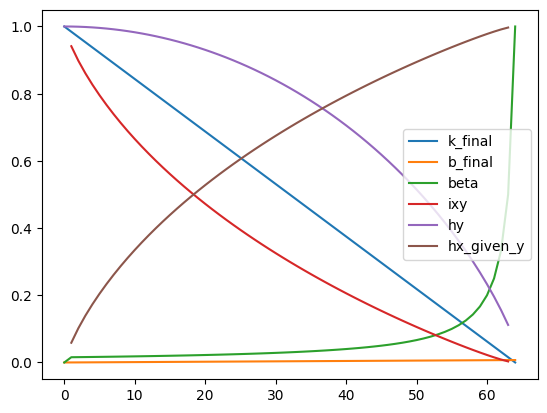

In [37]:
from diff_music.binary_diffusion import NoiseScheduler

test_scheduler = NoiseScheduler(64, 'linear', gamma=0.0072)

plt.plot(test_scheduler.k_final.cpu(), label='k_final')
plt.plot(test_scheduler.b_final.cpu(), label='b_final')
plt.plot(test_scheduler.beta.cpu(), label='beta')

ixy = []
hy = []
hx_given_y = []
for i in range(64):
    v = 0.5
    u = 1-v
    k = test_scheduler.k_final[i].item()
    b = test_scheduler.b_final[i].item()
    info_calc = InformationCalculator(u*(1-b), u*b, v*(1-k-b), v*(k+b))
    ixy.append(info_calc.i_xy())
    hy.append(info_calc.h_y())
    hx_given_y.append(info_calc.h_x_given_y())

plt.plot(ixy, label='ixy')
plt.plot(hy, label='hy')
plt.plot(hx_given_y, label='hx_given_y')
plt.legend()
print('k', test_scheduler.k_final[-1].item())
print('b', test_scheduler.b_final[-1].item())
print('beta', test_scheduler.beta[-1].item())


In [ ]:
import numpy as np



class InformationCalculator:
    def __init__(self, px0y0, px0y1, px1y0, px1y1):
        self.px0y0 = px0y0
        self.px0y1 = px0y1
        self.px1y0 = px1y0
        self.px1y1 = px1y1
        self.px0 = px0y0 + px0y1
        self.px1 = px1y0 + px1y1
        self.py0 = px0y0 + px1y0
        self.py1 = px0y1 + px1y1

    def h_x(self):
        return -self.px0*np.log2(self.px0)-self.px1*np.log2(self.px1)

    def h_y(self):
        return -self.py0*np.log2(self.py0)-self.py1*np.log2(self.py1)

    def h_xy(self):
        return -self.px0y0*np.log2(self.px0y0)-self.px0y1*np.log2(self.px0y1)-self.px1y0*np.log2(self.px1y0)-self.px1y1*np.log2(self.px1y1)

    def i_xy(self):
        return self.h_x()+self.h_y()-self.h_xy()
    
    def h_x_given_y(self):
        return self.h_xy()-self.h_y()

    def h_y_given_x(self):
        return self.h_xy()-self.h_x()
    
gamma = 0.0072


In [ ]:



v = 0.0072
u = 1-v
k = 0
b = 0.0072
info_calc = InformationCalculator(u*(1-b), u*b, v*(1-k-b), v*(k+b))

print('h_x', info_calc.h_x())
print('h_y', info_calc.h_y())
print('h_xy', info_calc.h_xy())
print('i_xy', info_calc.i_xy())
print('h_x_given_y', info_calc.h_x_given_y())
print('h_y_given_x', info_calc.h_y_given_x())

snr = info_calc.i_xy()/info_calc.h_x()
print('snr', snr)


h_x 0.06159798868964665
h_y 0.06159798868964665
h_xy 0.12319597737929325
i_xy 5.551115123125783e-17
h_x_given_y 0.061597988689646596
h_y_given_x 0.061597988689646596
snr 9.01184477157906e-16


In [81]:
from diff_music.binary_diffusion import NoiseScheduler
from torch.utils.data import DataLoader
dl = DataLoader(ds, batch_size=1, shuffle=True)


ones = 0
n = 0
i = 0
for x0 in dl:
    x0 = x0[0]
    n += x0.numel()
    ones += x0.sum().item()
    i += 1
    if i > 100:
        break
print(ones/n)

0.0070666734642214225


In [41]:
diff.scheduler.one_step(forwarding_x_t, 1).min(), diff.scheduler.one_step(forwarding_x_t, 1).max()

(tensor(0.0078, device='cuda:0'), tensor(0.9922, device='cuda:0'))

ticks per beat: 480
max tick: 0
tempo changes: 1
time sig: 0
key sig: 0
markers: 0
lyrics: False
instruments: 1

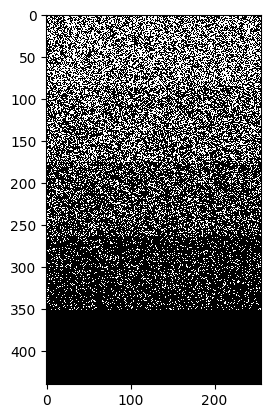

In [ ]:
import einops
import matplotlib.pyplot as plt
from music_data_analysis import Pianoroll
diff.eval()
with torch.no_grad():
    sampled = diff.sample((1, 1, 256, 88),return_all=True).detach().cpu()
T = sampled.shape[1]
num_display_steps = 4
display_steps = [0] + list(reversed([T -1 - i * (T // num_display_steps) for i in range(num_display_steps)]))

denoising_proc_img = einops.rearrange(sampled[:,display_steps].flip(3), 'b t c h w -> (t w) (b h) c')
plt.imshow(denoising_proc_img, cmap='gray', interpolation='none')

Pianoroll.from_tensor(sampled[0,-1,0], frames_per_beat=8, binary=True).to_midi('output.mid')

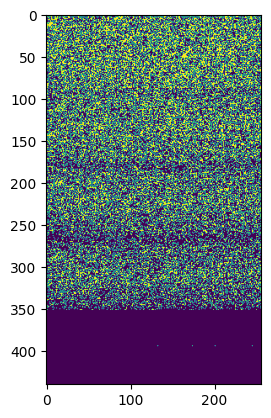

In [13]:
import matplotlib.pyplot as plt
plt.imshow(einops.rearrange(sampled[:,display_steps], 'b t c h w -> (t w) (b h) c'))

In [8]:
from music_data_analysis import Pianoroll
Pianoroll.from_tensor(ds[0], frames_per_beat=8, binary=True).to_midi('output.mid')

ticks per beat: 480
max tick: 0
tempo changes: 1
time sig: 0
key sig: 0
markers: 0
lyrics: False
instruments: 1

torch.cuda.empty_cache()

In [63]:
x0.shape

torch.Size([8, 256, 88])